In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = 'true'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' #omit info 
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from learnMSA.msa_hmm import (Align, Clustering, Configuration, Initializers,
                              Visualize)
from learnMSA.msa_hmm.SequenceDataset import SequenceDataset

2025-05-09 12:10:31.453291: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-09 12:10:31.469161: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-09 12:10:31.474176: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1746785432.613419  781811 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1746785432.653801  781811 cuda_executor.cc:1015] succ

### Ungapped alignment

In [2]:
name = "3_200"
suffix = "_no_gap"

# unaligned sequences
train_filename = f"../trees/data/dev_msa/{name}{suffix}.fa"
# reference alignment of all sequences
ref_filename = f"../trees/data/dev_msa/{name}{suffix}.fa"
# tree used to generate the sequences
tree_filename = f"../trees/data/dev_trees/{name}.nwk"

# number of distinct pHMMs
num_models = 1

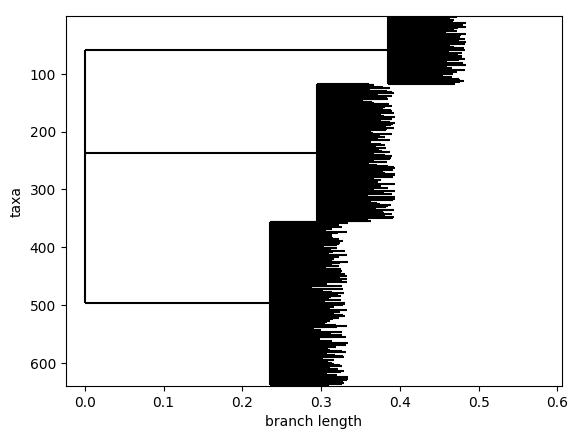

In [3]:
## Real tree used to generate the data
true_tree : Clustering.TreeHandler = Clustering.TreeHandler.read(tree_filename)
true_tree.draw(no_labels=True)

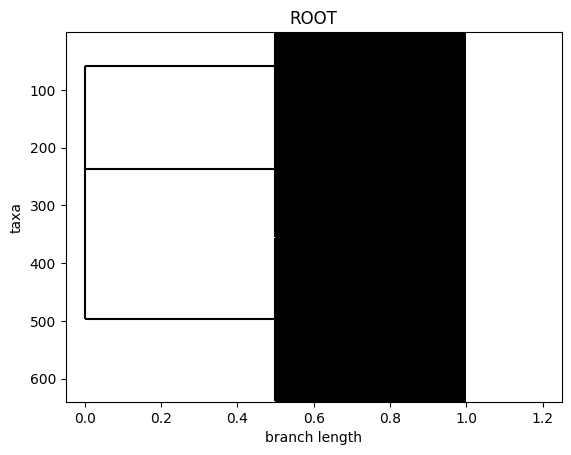

In [4]:
# compute a clustering from the unaligned sequences and a rough initial tree 
# with short branches
clustering : pd.DataFrame = Clustering.compute_clustering(
    train_filename, cluster_seq_id=0.7, linear=False
)
tree_handler = Clustering.cluster_tree(clustering, branch_length=0.5)
tree_handler.draw(no_labels=True)

Falsely clustered sequences can lead to poor alignments. We'll have to account for that.

Problem: How to do that without computing emissions and transitions w.r.t. all models?

In [5]:
# compute cluster precision
true_cluster_indices = true_tree.get_parent_indices_by_height(0)
cluster_indices = tree_handler.get_parent_indices_by_height(0)

true_positives = 0
positives = 0   
trues = 0   

leaf_names = tree_handler.node_names[:tree_handler.num_leaves]
for i,u_name in enumerate(leaf_names):
    for v_name in leaf_names[i+1:]:
        u = tree_handler.nodes[u_name]
        v = tree_handler.nodes[v_name]
        tu = true_tree.nodes[u_name]
        tv = true_tree.nodes[v_name]
        positives += int(u.parent == v.parent)
        trues += int(tu.parent == tv.parent)
        true_positives += int(u.parent == v.parent and tu.parent == tv.parent)

print("Cluster precision:", true_positives/positives)
print("Cluster recall:", true_positives/trues)
print("True number of clusters: ", true_tree.num_anc-1)
print("Predicted number of clusters: ", tree_handler.num_anc-1)

Cluster precision: 1.0
Cluster recall: 1.0
True number of clusters:  3
Predicted number of clusters:  3


In [6]:
out_filename = "test/data/ungapped_tree_loss.fasta"
with SequenceDataset(train_filename, fmt="fasta") as data:
    config = Configuration.make_default(
        num_models, 
        tree_handler=tree_handler,
        tree_loss_weight=0., #independent HMMs, no loss
        use_tree_transitioner=False,
        perturbation_prob_min=0.0,
        perturbation_prob_init=0.0,
        perturbation_prob_decay=0.0,
        propagate_root=False
    )
    config["epochs"] = [10, 5, 10]
    config["max_surgery_runs"] = 1
    config["len_mul"] = 1.0
    initial_model_length_callback = partial(
        Align.get_initial_model_lengths, random=False
    )
    alignment_model = Align.run_learnMSA(
        data,
        out_filename,
        config, 
        verbose=True,
        align_insertions=True,
        initial_model_length_callback=initial_model_length_callback
    )

Training of 1 models on file 3_200_no_gap.fa
Configuration: 
{
num_models : 1
transitioner : ProfileHMMTransitioner(
 transition_init=
    {
    begin_to_match : DefaultEntry() , match_to_end : DefaultExit() , 
    match_to_match : DefaultMatchTransition(1) , match_to_insert : DefaultMatchTransition(-1) , 
    insert_to_match : Norm(0, 0.1) , insert_to_insert : Norm(-0.5, 0.1) , 
    match_to_delete : DefaultMatchTransition(-1) , delete_to_match : Norm(0, 0.1) , 
    delete_to_delete : Norm(-0.5, 0.1) , left_flank_loop : Norm(0, 0.1) , 
    left_flank_exit : Norm(-1, 0.1) , right_flank_loop : Norm(0, 0.1) , 
    right_flank_exit : Norm(-1, 0.1) , unannotated_segment_loop : Norm(0, 0.1) , 
    unannotated_segment_exit : Norm(-1, 0.1) , end_to_unannotated_segment : Norm(-9, 0.1) , 
    end_to_right_flank : Norm(0, 0.1) , end_to_terminal : Norm(0, 0.1)
    },
 flank_init=Const(0.0),
 prior=ProfileHMMTransitionPrior(match_comp=1, insert_comp=1, delete_comp=1, alpha_flank=7000, alpha_single

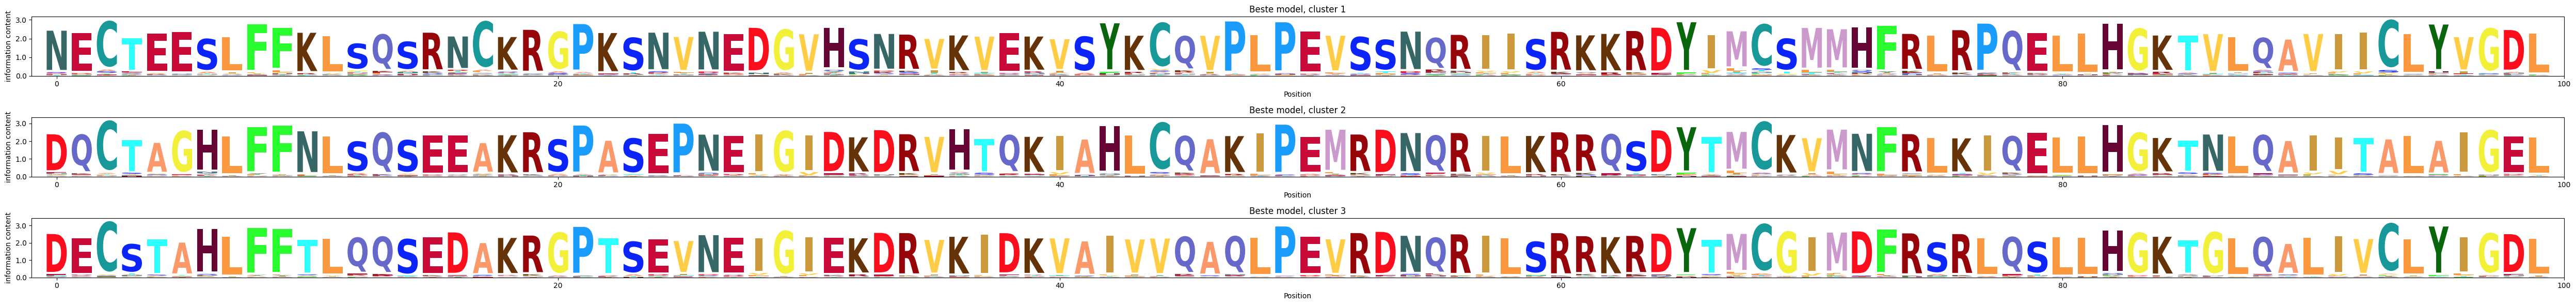

In [7]:
num_clust = tree_handler.num_anc-1
fig, axes = plt.subplots(num_clust, 1, figsize=(10, 5))
for i in range(num_clust):
    ax = axes[i]
    ax.set_title(f"Beste model, cluster {i+1}")
    ax.set_xlabel("Position")
    ax.set_ylabel("Information content")
    Visualize.plot_logo(
        alignment_model, alignment_model.best_model, ax, cluster_index=i
    )
plt.tight_layout()

In [8]:
B = alignment_model.msa_hmm_layer.cell.emitter[0].make_B().numpy()

In [9]:
B[0, :, 1]

array([[1.0516567e-02, 1.3926455e-03, 9.2070818e-01, 1.4073024e-02,
        1.3485953e-03, 1.3151509e-03, 4.6431124e-03, 1.1599028e-03,
        5.9190365e-03, 1.4352620e-03, 2.5169128e-03, 1.9570917e-03,
        8.2043856e-03, 6.5052183e-04, 6.1698066e-04, 1.8529195e-02,
        2.1662680e-03, 1.0884604e-04, 5.8662432e-04, 2.1368524e-03,
        1.4844544e-05, 3.2273334e-08, 6.6699151e-33, 0.0000000e+00],
       [1.8328644e-02, 1.1048686e-03, 1.8335145e-02, 8.9963770e-01,
        1.5959543e-03, 3.2370419e-03, 2.8091963e-02, 1.1708207e-02,
        1.5581307e-03, 1.1279895e-03, 1.7391475e-03, 3.9493502e-03,
        6.1883929e-04, 6.3416624e-04, 2.9340193e-03, 1.6790429e-03,
        1.4081654e-03, 1.8194734e-04, 5.8532413e-04, 1.5300449e-03,
        1.4321220e-05, 2.6657082e-08, 6.5338524e-33, 0.0000000e+00],
       [2.0268348e-03, 1.1816588e-03, 5.7906290e-03, 9.2409426e-01,
        1.6688028e-03, 2.9075779e-03, 3.8308211e-02, 2.8223395e-03,
        5.9259060e-04, 1.2045352e-03, 3.773257

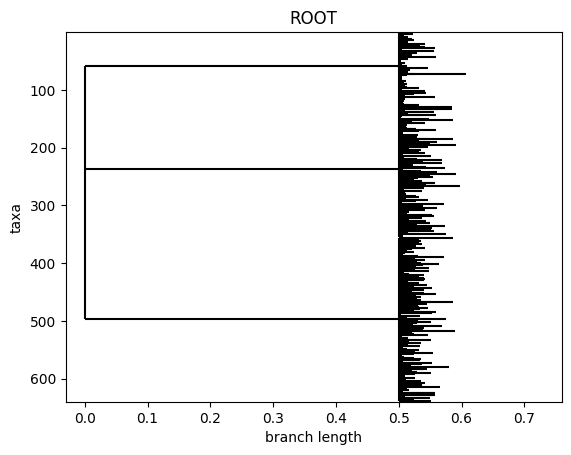

In [10]:
# plot the tree after training
# this requires to get both the branch lengths of the tree emitter for the 
# ancestral past of the tree as well as the lengths of all leaf branches from 
# the ancestral probability layer

# ancestral part
tree_emitter = alignment_model.msa_hmm_layer.cell.emitter[0]
branch_lengths = tree_emitter.get_branch_lengths().numpy()
branch_lengths = branch_lengths[:, alignment_model.best_model]
branch_lengths = branch_lengths[:, np.newaxis]

# leaf part
anc_prob_layer = alignment_model.encoder_model.layers[-3]
leaf_branch_lengths = anc_prob_layer.make_times().numpy()
leaf_branch_lengths = leaf_branch_lengths[:,alignment_model.best_model]
leaf_branch_lengths = leaf_branch_lengths[:,np.newaxis]

branch_lengths = np.concatenate((leaf_branch_lengths, branch_lengths), axis=0)

tree_emitter.tree_handler.set_branch_lengths(branch_lengths)
tree_emitter.tree_handler.draw(no_labels=True)